# Detecting Maclicious URLs using Machine Learning<br>
The malicious urls can be detected using the lexical features along with tokenization of the url strings. I aim to build a basic binary classifier which would help classify the URLs as malicious or benign.

Steps followed in building the machine learning classifier<br>
1. Data Preprocessing / Feature Engineering
2. Data Visualization
3. Building Machine Learning Models using Lexical Features.
4. Building Machine Learning Models using Lexical Features and Tokenization. (Will Update this part)

Importing The Dependencies

In [75]:

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input"))


['urldata.csv']


In [76]:
!pip install catboost

You are using pip version 19.0.3, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [77]:
!pip install xgboost

You are using pip version 19.0.3, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [78]:
urldata = pd.read_csv("../input/urldata.csv")

In [79]:
urldata.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [80]:
#Removing the unnamed columns as it is not necesary.
urldata = urldata.drop('Unnamed: 0',axis=1)

In [81]:
urldata.head()

,url,label,result
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


In [82]:
urldata.shape

(450176, 3)

In [83]:
urldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 3 columns):
url       450176 non-null object
label     450176 non-null object
result    450176 non-null int64
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


Checking Missing Values

In [84]:
urldata.isnull().sum()

url       0
label     0
result    0
dtype: int64

No missing values in any column.

# 1. DATA PREPROCESSING

The following features will be extracted from the URL for classification. <br>
<ol>
    <li>Length Features
    <ul>
        <li>Length Of Url</li>
        <li>Length of Hostname</li>
        <li>Length Of Path</li>
        <li>Length Of First Directory</li>
        <li>Length Of Top Level Domain</li>
    </ul>
    </li>
    <br>
   <li>Count Features
    <ul>
    <li>Count Of  '-'</li>
    <li>Count Of '@'</li>
    <li>Count Of '?'</li>
    <li>Count Of '%'</li>
    <li>Count Of '.'</li>
    <li>Count Of '='</li>
    <li>Count Of 'http'</li>
    <li>Count Of 'www'</li>
    <li>Count Of Digits</li>
    <li>Count Of Letters</li>
    <li>Count Of Number Of Directories</li>
    </ul>
    </li>
    <br>
    <li>Binary Features
    <ul>
        <li>Use of IP or not</li>
        <li>Use of Shortening URL or not</li>
    </ul>
    </li>
    
</ol>

Apart from the lexical features, we will use TFID - Term Frequency Inverse Document as well.

### 1.1 Length Features

In [85]:
!pip install tld

You are using pip version 19.0.3, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [86]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

In [87]:
#Length of URL
urldata['url_length'] = urldata['url'].apply(lambda i: len(str(i)))

In [88]:
#Hostname Length
urldata['hostname_length'] = urldata['url'].apply(lambda i: len(urlparse(i).netloc))

In [89]:
#Path Length
urldata['path_length'] = urldata['url'].apply(lambda i: len(urlparse(i).path))

In [90]:
#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

urldata['fd_length'] = urldata['url'].apply(lambda i: fd_length(i))

In [91]:
#Length of Top Level Domain
urldata['tld'] = urldata['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

urldata['tld_length'] = urldata['tld'].apply(lambda i: tld_length(i))

In [92]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld,tld_length
0,https://www.google.com,benign,0,22,14,0,0,com,3
1,https://www.youtube.com,benign,0,23,15,0,0,com,3
2,https://www.facebook.com,benign,0,24,16,0,0,com,3
3,https://www.baidu.com,benign,0,21,13,0,0,com,3
4,https://www.wikipedia.org,benign,0,25,17,0,0,org,3


In [93]:
urldata = urldata.drop("tld",1)

Dataset after extracting length features

In [94]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length
0,https://www.google.com,benign,0,22,14,0,0,3
1,https://www.youtube.com,benign,0,23,15,0,0,3
2,https://www.facebook.com,benign,0,24,16,0,0,3
3,https://www.baidu.com,benign,0,21,13,0,0,3
4,https://www.wikipedia.org,benign,0,25,17,0,0,3


### 1.2 Count Features

In [95]:
urldata['count-'] = urldata['url'].apply(lambda i: i.count('-'))

In [96]:
urldata['count@'] = urldata['url'].apply(lambda i: i.count('@'))

In [97]:
urldata['count?'] = urldata['url'].apply(lambda i: i.count('?'))

In [98]:
urldata['count%'] = urldata['url'].apply(lambda i: i.count('%'))

In [99]:
urldata['count.'] = urldata['url'].apply(lambda i: i.count('.'))

In [100]:
urldata['count='] = urldata['url'].apply(lambda i: i.count('='))

In [101]:
urldata['count-http'] = urldata['url'].apply(lambda i : i.count('http'))

In [102]:
urldata['count-https'] = urldata['url'].apply(lambda i : i.count('https'))

In [103]:
urldata['count-www'] = urldata['url'].apply(lambda i: i.count('www'))

In [104]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
urldata['count-digits']= urldata['url'].apply(lambda i: digit_count(i))

In [105]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
urldata['count-letters']= urldata['url'].apply(lambda i: letter_count(i))

In [106]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
urldata['count_dir'] = urldata['url'].apply(lambda i: no_of_dir(i))

Data after extracting Count Features

In [107]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir
0,https://www.google.com,benign,0,22,14,0,0,3,0,0,0,0,2,0,1,1,1,0,17,0
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,0,0,0,2,0,1,1,1,0,18,0
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,0,0,0,2,0,1,1,1,0,19,0
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,0,0,0,2,0,1,1,1,0,16,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,0,0,0,2,0,1,1,1,0,20,0


### 1.3 Binary Features

In [108]:
import re

In [109]:
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return -1
    else:
        # print 'No matching pattern found'
        return 1
urldata['use_of_ip'] = urldata['url'].apply(lambda i: having_ip_address(i))

In [110]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return -1
    else:
        return 1
urldata['short_url'] = urldata['url'].apply(lambda i: shortening_service(i))

Data after extracting Binary Features

In [111]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,https://www.google.com,benign,0,22,14,0,0,3,0,0,0,0,2,0,1,1,1,0,17,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,0,0,0,2,0,1,1,1,0,18,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,0,0,0,2,0,1,1,1,0,19,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,0,0,0,2,0,1,1,1,0,16,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,0,0,0,2,0,1,1,1,0,20,0,1,1


# 2. Data Visualization

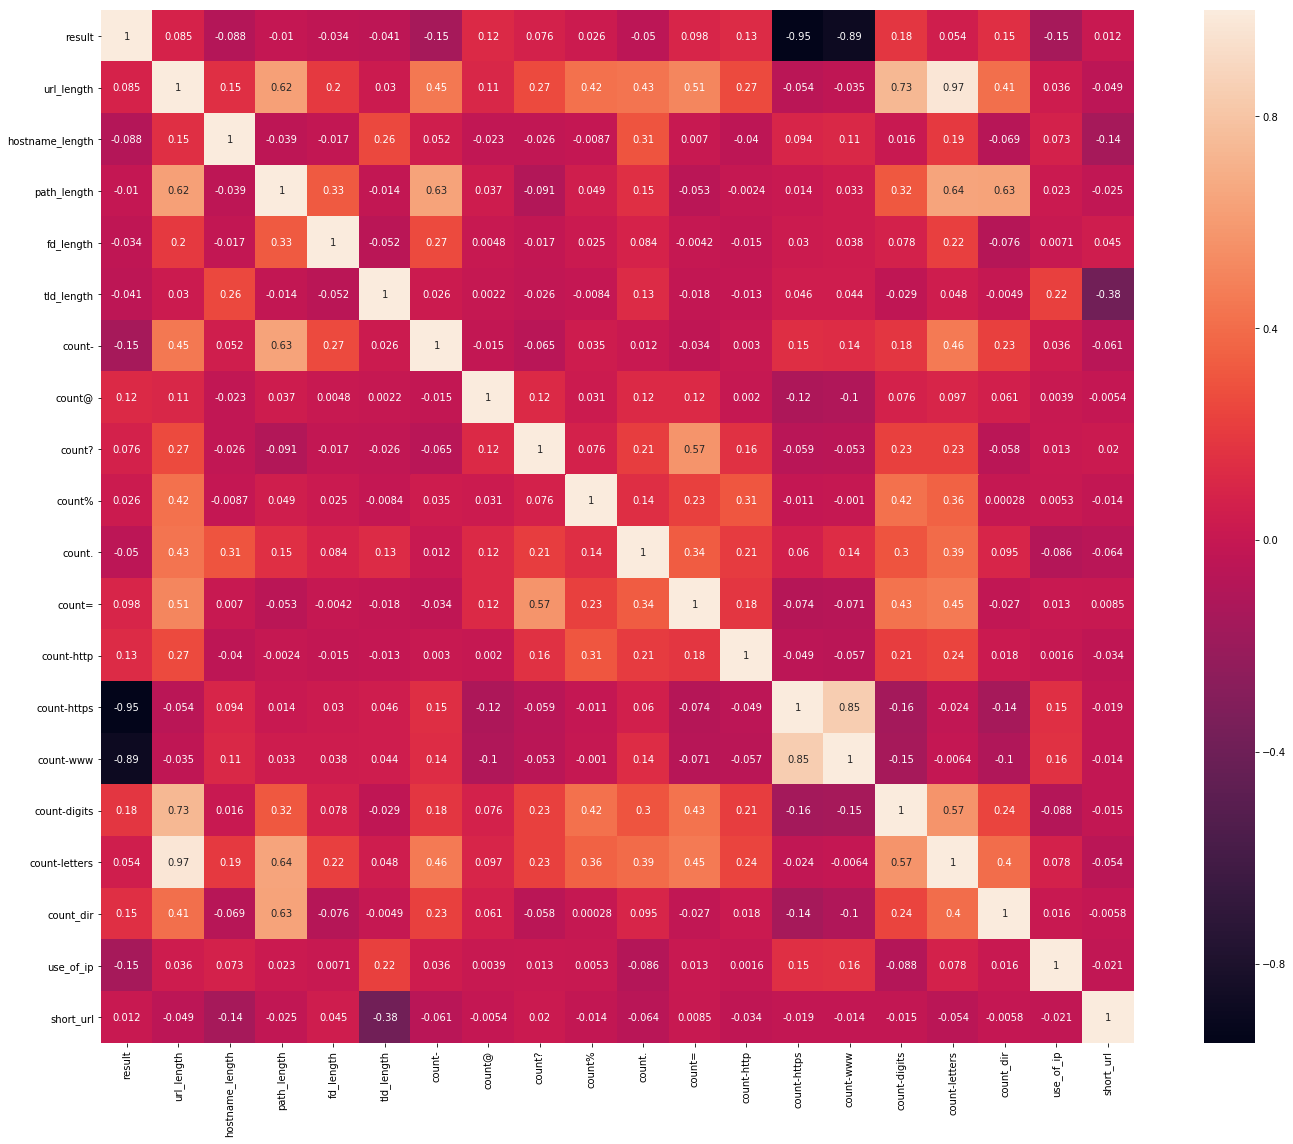

In [112]:
#Heatmap
corrmat = urldata.corr()
f, ax = plt.subplots(figsize=(25,19))
sns.heatmap(corrmat, square=True, annot = True, annot_kws={'size':10})

Text(0, 0.5, 'Number Of URLs')

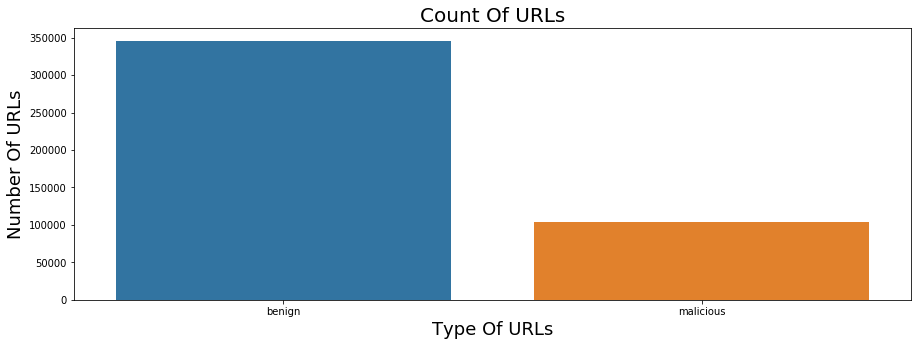

In [113]:
plt.figure(figsize=(15,5))
sns.countplot(x='label',data=urldata)
plt.title("Count Of URLs",fontsize=20)
plt.xlabel("Type Of URLs",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

In [114]:
print("Percent Of Malicious URLs:{:.2f} %".format(len(urldata[urldata['label']=='malicious'])/len(urldata['label'])*100))
print("Percent Of Benign URLs:{:.2f} %".format(len(urldata[urldata['label']=='benign'])/len(urldata['label'])*100))

Percent Of Malicious URLs:23.20 %
Percent Of Benign URLs:76.80 %


The data shows a class imbalance to some extent.

(0, 1000)

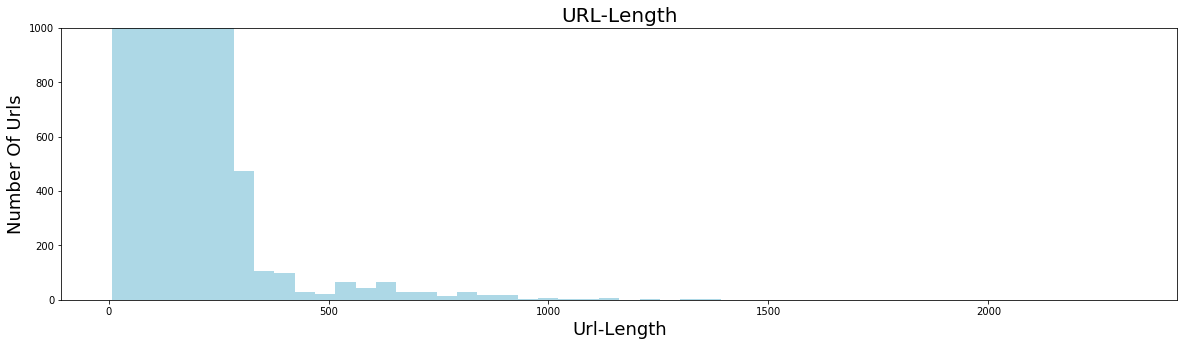

In [115]:
plt.figure(figsize=(20,5))
plt.hist(urldata['url_length'],bins=50,color='LightBlue')
plt.title("URL-Length",fontsize=20)
plt.xlabel("Url-Length",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)


(0, 1000)

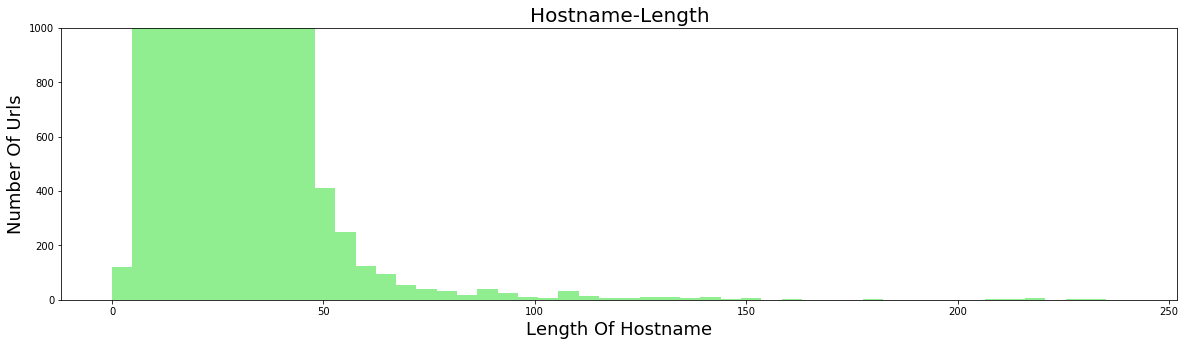

In [116]:
plt.figure(figsize=(20,5))
plt.hist(urldata['hostname_length'],bins=50,color='Lightgreen')
plt.title("Hostname-Length",fontsize=20)
plt.xlabel("Length Of Hostname",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

(0, 1000)

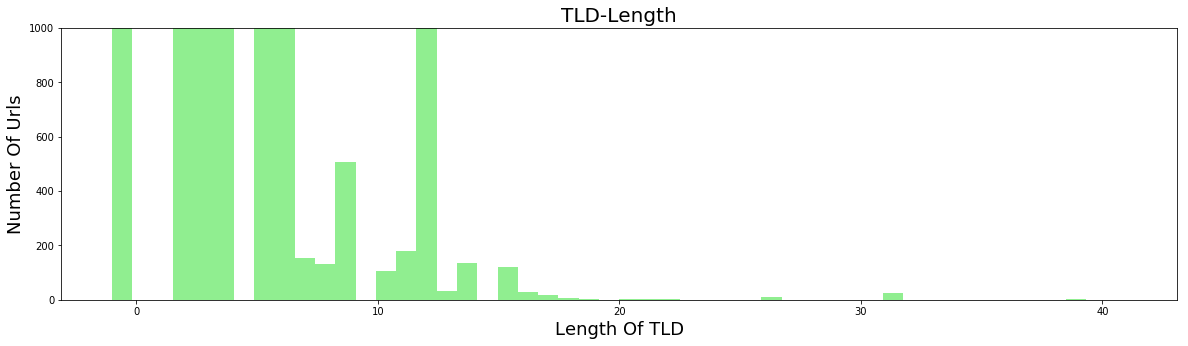

In [117]:
plt.figure(figsize=(20,5))
plt.hist(urldata['tld_length'],bins=50,color='Lightgreen')
plt.title("TLD-Length",fontsize=20)
plt.xlabel("Length Of TLD",fontsize=18)
plt.ylabel("Number Of Urls",fontsize=18)
plt.ylim(0,1000)

Text(0, 0.5, 'Number Of URLs')

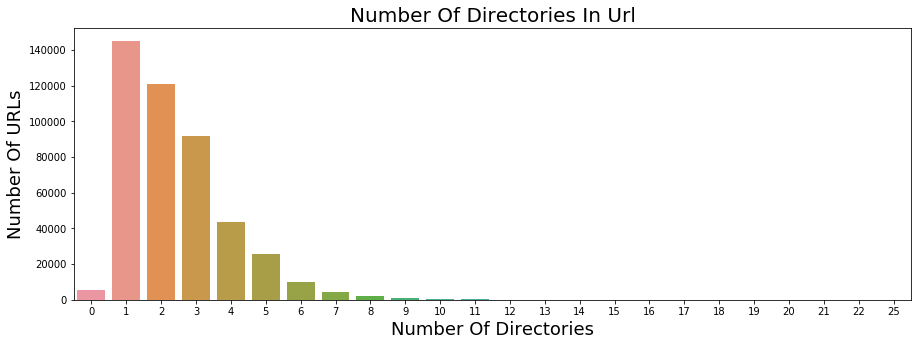

In [118]:
plt.figure(figsize=(15,5))
plt.title("Number Of Directories In Url",fontsize=20)
sns.countplot(x='count_dir',data=urldata)
plt.xlabel("Number Of Directories",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

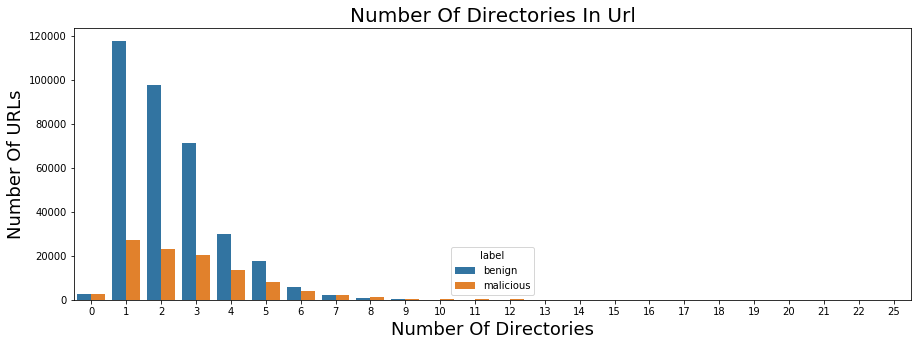

In [119]:
plt.figure(figsize=(15,5))
plt.title("Number Of Directories In Url",fontsize=20)
sns.countplot(x='count_dir',data=urldata,hue='label')
plt.xlabel("Number Of Directories",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

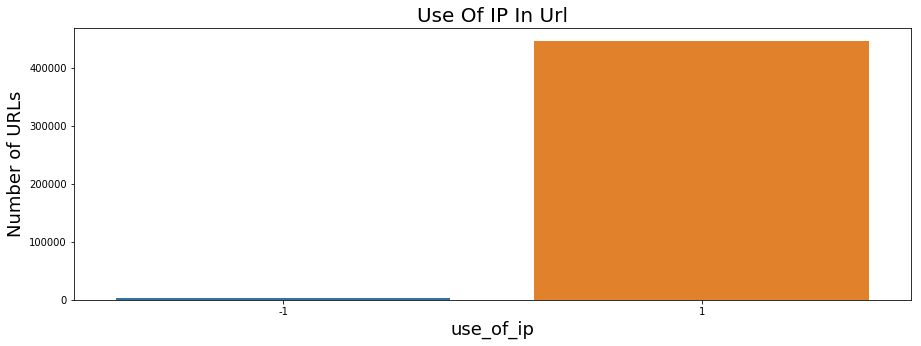

In [120]:
plt.figure(figsize=(15,5))
plt.title("Use Of IP In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)

sns.countplot(urldata['use_of_ip'])
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

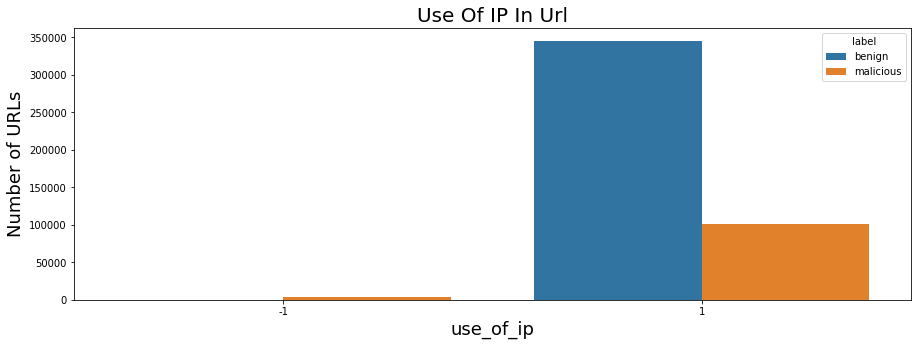

In [121]:
plt.figure(figsize=(15,5))
plt.title("Use Of IP In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)
plt.ylabel("Number of URLs",fontsize=18)
sns.countplot(urldata['use_of_ip'],hue='label',data=urldata)
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

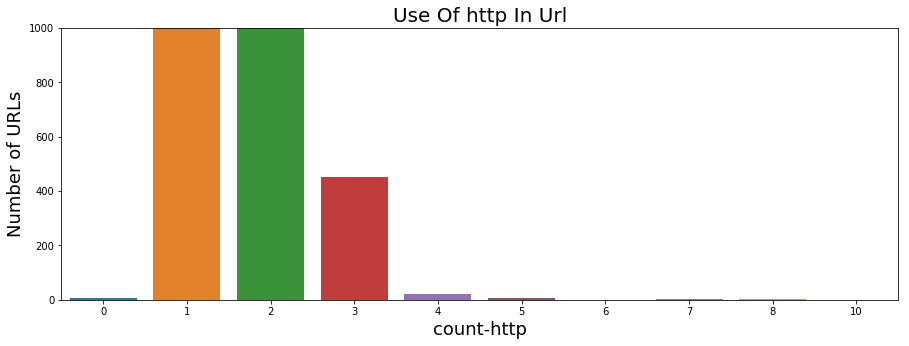

In [122]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Use Of IP",fontsize=18)
plt.ylim((0,1000))
sns.countplot(urldata['count-http'])
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

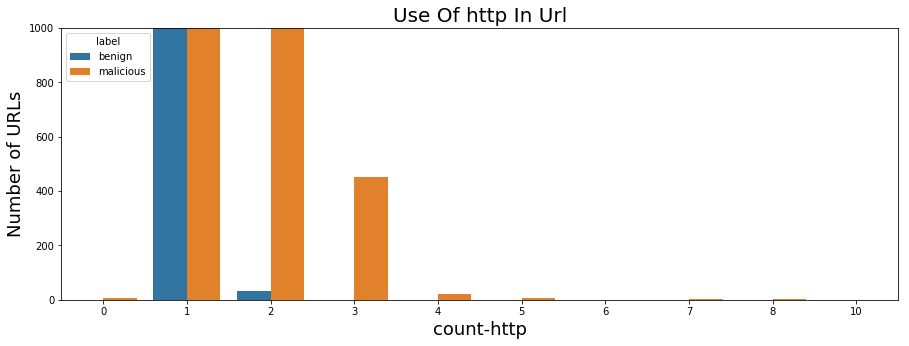

In [123]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Count Of http",fontsize=18)
plt.ylabel("Number of URLs",fontsize=18)
plt.ylim((0,1000))
sns.countplot(urldata['count-http'],hue='label',data=urldata)
plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number of URLs')

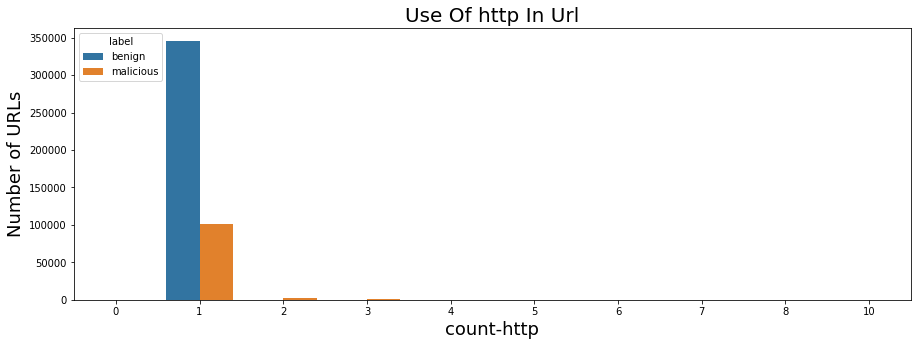

In [124]:
plt.figure(figsize=(15,5))
plt.title("Use Of http In Url",fontsize=20)
plt.xlabel("Count Of http",fontsize=18)

sns.countplot(urldata['count-http'],hue='label',data=urldata)

plt.ylabel("Number of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

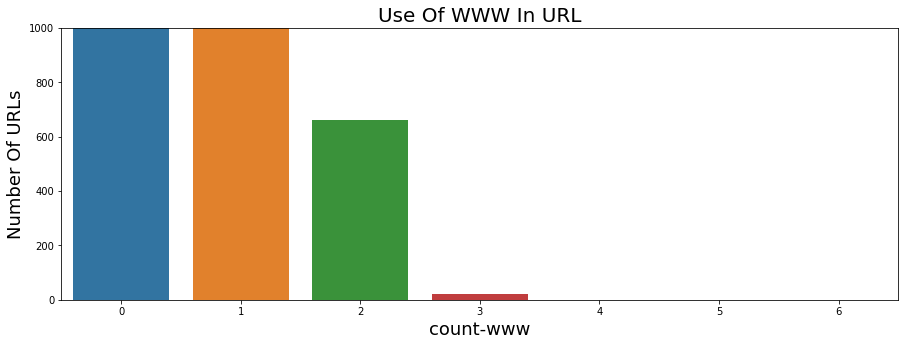

In [125]:
plt.figure(figsize=(15,5))
plt.title("Use Of WWW In URL",fontsize=20)
plt.xlabel("Count Of WWW",fontsize=18)
sns.countplot(urldata['count-www'])
plt.ylim(0,1000)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

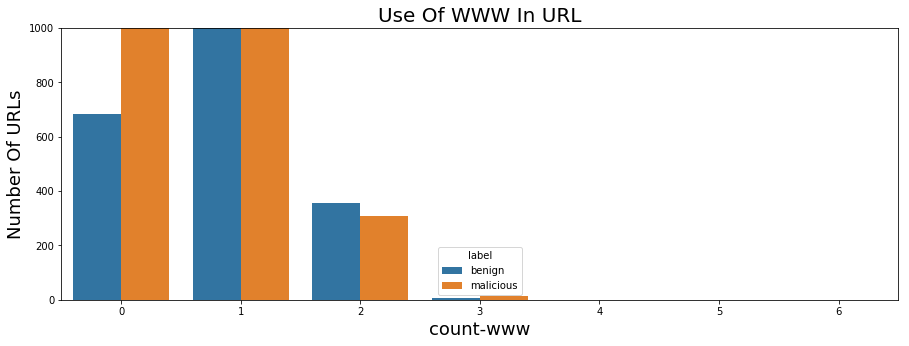

In [126]:
plt.figure(figsize=(15,5))
plt.title("Use Of WWW In URL",fontsize=20)
plt.xlabel("Count Of WWW",fontsize=18)

sns.countplot(urldata['count-www'],hue='label',data=urldata)
plt.ylim(0,1000)
plt.ylabel("Number Of URLs",fontsize=18)

# 3. Building Models Using Lexical Features Only


<br>1. Logistic Regression
<br>2. XGBoost Classifier
<br>3. Random Forest

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

from xgboost.sklearn import XGBClassifier

from sklearn.linear_model import LogisticRegression



In [128]:
#Independent Variables
x = urldata[['hostname_length',
       'path_length', 'fd_length', 'tld_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']]

#Dependent Variable
y = urldata['result']

## 3.1 Train test split

In [129]:
#Oversampling using SMOTE
from imblearn.over_sampling import SMOTE

x_sample, y_sample = SMOTE().fit_sample(x, y.values.ravel())

x_sample = pd.DataFrame(x_sample)
y_sample = pd.DataFrame(y_sample)

# checking the sizes of the sample data
print("Size of x-sample :", x_sample.shape)
print("Size of y-sample :", y_sample.shape)

Size of x-sample : (691476, 17)
Size of y-sample : (691476, 1)


In [130]:
#Train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size = 0.2, random_state = 1234)
print("Shape of x_train: ", x_train.shape)
print("Shape of x_valid: ", x_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_valid: ", y_test.shape)

Shape of x_train:  (553180, 17)
Shape of x_valid:  (138296, 17)
Shape of y_train:  (553180, 1)
Shape of y_valid:  (138296, 1)


## 3.2 XGBoost Classifier

In [131]:
#XGBoost Classifier
xgb_model = XGBClassifier()
xgb_model.fit(x_train,y_train)

xg_predictions = xgb_model.predict(x_test)
accuracy_score(y_test,xg_predictions)


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9973318100306588

In [132]:
cm = pd.DataFrame(confusion_matrix(y_test,xg_predictions))
cm.columns = ['Predicted 0', 'Predicted 1']
cm = cm.rename(index = {0:'Actual 0',1:'Actual 1'})
cm

,Predicted 0,Predicted 1
Actual 0,69056,167
Actual 1,202,68871


## 3.3 Random Forest

In [133]:
#Random Forest
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_predictions = rfc.predict(x_test)
accuracy_score(y_test, rfc_predictions)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.9978452015965754

In [134]:
cm = pd.DataFrame(confusion_matrix(y_test,rfc_predictions))
cm.columns = ['Predicted 0', 'Predicted 1']
cm = cm.rename(index = {0:'Actual 0',1:'Actual 1'})
cm

,Predicted 0,Predicted 1
Actual 0,69099,124
Actual 1,174,68899


## 3.4 Logistic Regression

In [135]:
#Logistic Regression
log_model = LogisticRegression()
log_model.fit(x_train,y_train)

log_predictions = log_model.predict(x_test)
accuracy_score(y_test,log_predictions)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9971148840168913

In [136]:
cm_df = pd.DataFrame(confusion_matrix(y_test,log_predictions))
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index = {0:'Actual 0',1:'Actual 1'})
cm_df

,Predicted 0,Predicted 1
Actual 0,69054,169
Actual 1,230,68843


In [147]:
#Overall Accuracy table
import numpy as np
model = np.array(['XGBClassifier', 'Random Forest', 'Logistic Regression'])
scr = np.array([accuracy_score(y_test,xg_predictions)*100, accuracy_score(y_test, rfc_predictions)*100, accuracy_score(y_test,log_predictions)*100])
tbl = pd.DataFrame({"Model": model,"Accuracy Score": scr})
tbl

,Model,Accuracy Score
0,XGBClassifier,99.733181
1,Random Forest,99.784520
2,Logistic Regression,99.711488


Overall all the models showed great results with decent accuracy and low error rate.<br>
The high accuracy can be due to the class imbalance situation which is not fixed yet.